# "Plain" 2d-CNN to classify emotions




#Mounting GD

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


#Utils used for experiments
##On the final stage, those are to be inlcuded in a separate .py file

In [ ]:
import IPython.display as ipd
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
from sklearn import metrics 
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from tensorflow import keras

Modified labels


Vizualizing MFCCs and wave 

#Loading pre-computed features and corresponding labels

In [ ]:
import ast
featuresdf = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/data/IEMOCAP_full_release/features.csv",index_col=[0])
featuresdf['feature'] = featuresdf['feature'].apply(lambda x: np.array(ast.literal_eval(x))) 


##Converting features to numpy arrays


In [ ]:
features_temp = featuresdf['feature']
X = [l.tolist() for l in features_temp]
X = np.array(X)
X.shape

(5531, 40, 517)

Encode labels to onehot

In [ ]:
from sklearn.preprocessing import LabelEncoder
y = np.array(featuresdf.class_label.tolist())
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

##CNN



In [ ]:
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.initializers import glorot_uniform
def CNN(input_shape=(40,517,1),classes = 4):
  input = Input(input_shape)
  x = Conv2D(64,(8,8), padding='same',activation='relu',kernel_initializer=glorot_uniform())(input)
  x = BatchNormalization()(x)
  x = Conv2D(64,(8,8), padding='same',activation='relu',kernel_initializer=glorot_uniform())(x)
  x = BatchNormalization()(x)
  x = Conv2D(128,(5,5), padding='same',activation='relu',kernel_initializer=glorot_uniform())(x)
  x = BatchNormalization()(x)
  x = Conv2D(128,(5,5), padding='same',activation='relu',kernel_initializer=glorot_uniform())(x)
  x = BatchNormalization()(x)
  x = Conv2D(256,(3,3), padding='same',activation='relu',kernel_initializer=glorot_uniform())(x)
  x = Dropout(0.3)(x)
  x = BatchNormalization()(x)
  x = GlobalMaxPooling2D()(x)
  x = Dense(128, activation='relu',kernel_initializer=glorot_uniform())(x)
  x = Dropout(0.1)(x)
  x = Dense(64, activation='relu',kernel_initializer=glorot_uniform())(x)
  x = Dropout(0.1)(x)
  output = Dense(classes, activation='softmax',kernel_initializer=glorot_uniform())(x)
  model = Model(inputs=input, outputs=output, name='Plain_CNN')
  return model

In [ ]:
CNN().summary()

Model: "Plain_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 40, 517, 1)]      0         
                                                                 
 conv2d_25 (Conv2D)          (None, 40, 517, 64)       4160      
                                                                 
 batch_normalization_5 (Batc  (None, 40, 517, 64)      256       
 hNormalization)                                                 
                                                                 
 conv2d_26 (Conv2D)          (None, 40, 517, 64)       262208    
                                                                 
 batch_normalization_6 (Batc  (None, 40, 517, 64)      256       
 hNormalization)                                                 
                                                                 
 conv2d_27 (Conv2D)          (None, 40, 517, 128)      20

In [ ]:
def k_fold_fit_re(model_type, X, yy, lr = 0.0001, folds=10, numepoch = 100, batchsize = 32):
  from sklearn.model_selection import KFold
  from sklearn.metrics import ConfusionMatrixDisplay
  from sklearn.metrics import confusion_matrix
  from tensorflow.keras.optimizers import SGD
  from sklearn.metrics import f1_score
  from functools import reduce
  #pred and ground truth for overall conf matrix
  truth = []
  predicted = []
  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []
  f1_per_fold = []
  verbosity = 1
  # Define the K-fold Cross Validator
  kfold = KFold(n_splits=folds, shuffle=True)
  fold_no = 1
  for train, test in kfold.split(X, yy):
    model = CNN()
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model
    history = model.fit(X[train],
                yy[train],
                batch_size=batchsize,
                epochs=numepoch,
                verbose=verbosity)
    # Generate generalization metrics
    scores = model.evaluate(X[test], yy[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    #Confusion matrix construction
    y_pred = np.argmax(model.predict(X[test]), axis=-1)
    matrix = metrics.confusion_matrix(yy[test].argmax(axis=1), y_pred)
    #f1 score
    f1_score_temp = f1_score(yy[test].argmax(axis=1), y_pred, average='weighted')
    f1_per_fold.append(f1_score_temp*100)
    #append predicted and ground truth to corresponding lists
    truth.append(yy[test].argmax(axis=1).tolist())
    predicted.append(y_pred.tolist())
    #conf matrix contd
    rounded_labels= np.unique(le.inverse_transform(np.argmax(yy[test], axis=1)))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    # == Print average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - F1: {f1_per_fold[i]}')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> F1: {np.mean(f1_per_fold)}')
    print('------------------------------------------------------------------------')
  #flatten the nested lists
  print('Confusion matrix over all folders')
  truth = reduce(lambda x,y: x+y, truth)
  predicted = reduce(lambda x,y:x+y, predicted)
  matrix = metrics.confusion_matrix(truth, predicted)
  rounded_labels= np.unique(le.inverse_transform(np.argmax(yy, axis=1)))
  disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
  disp.plot(cmap=plt.cm.Blues)
  plt.show()

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
156/156 [==============================] - 35s 219ms/step - loss: 1.6667 - accuracy: 0.3848
Epoch 2/50
156/156 [==============================] - 34s 219ms/step - loss: 1.1773 - accuracy: 0.4561
Epoch 3/50
156/156 [==============================] - 34s 219ms/step - loss: 1.1399 - accuracy: 0.4734
Epoch 4/50
156/156 [==============================] - 34s 219ms/step - loss: 1.0739 - accuracy: 0.5192
Epoch 5/50
156/156 [==============================] - 34s 219ms/step - loss: 1.0808 - accuracy: 0.5047
Epoch 6/50
156/156 [==============================] - 34s 219ms/step - loss: 1.0536 - accuracy: 0.5278
Epoch 7/50
156/156 [==============================] - 34s 219ms/step - loss: 1.0271 - accuracy: 0.5435
Epoch 8/50
156/156 [==============================] - 34s 219ms/step - loss: 0.9958 - accuracy: 0.5578
Epoch 9/50
156/156 [==============================] - 34s 219ms/step - loss: 0.

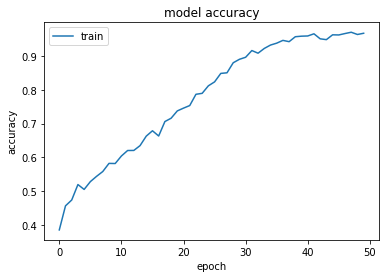

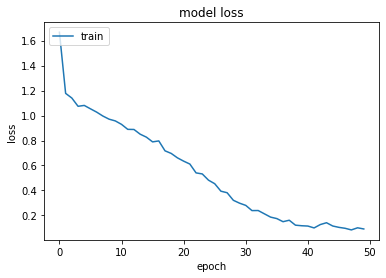

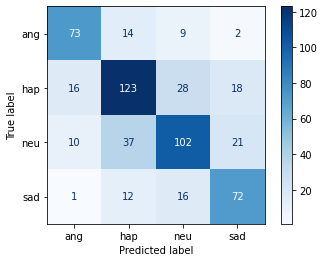

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0442649126052856 - Accuracy: 66.7870044708252% - F1: 66.71505397195095
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 66.7870044708252 (+- 0.0)
> Loss: 1.0442649126052856
> F1: 66.71505397195095
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
156/156 [==============================] - 35s 219ms/step - loss: 1.6139 - accuracy: 0.3982
Epoch 2/50
156/156 [==============================] - 34s 219ms/step - loss: 1.1424 - accuracy: 0.4646
Epoch 3/50
156/156 [==============================] - 34s 219ms/step - loss: 1.1143 - accuracy: 0.4745
Epoch 4/50
156/156 [==============================] - 34s 219ms/step - loss: 1

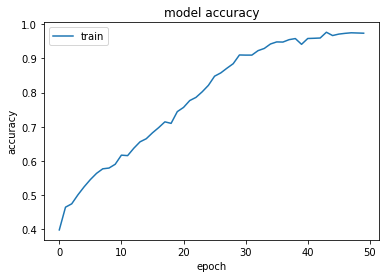

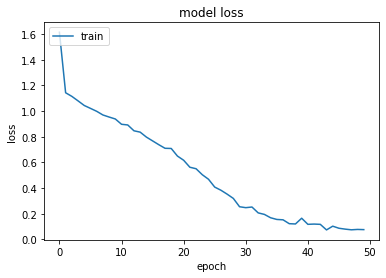

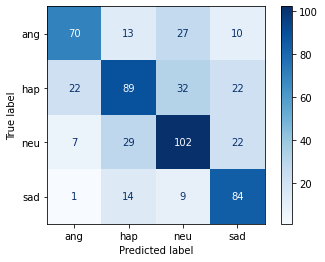

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0442649126052856 - Accuracy: 66.7870044708252% - F1: 66.71505397195095
------------------------------------------------------------------------
> Fold 2 - Loss: 1.3183014392852783 - Accuracy: 62.386977672576904% - F1: 62.164694451640834
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 64.58699107170105 (+- 2.2000133991241455)
> Loss: 1.181283175945282
> F1: 64.4398742117959
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50
156/156 [==============================] - 35s 220ms/step - loss: 1.6967 - accuracy: 0.3939
Epoch 2/50
156/156 [==============================] - 34s 220ms/step - loss: 1.1970 - accuracy: 0.4405
E

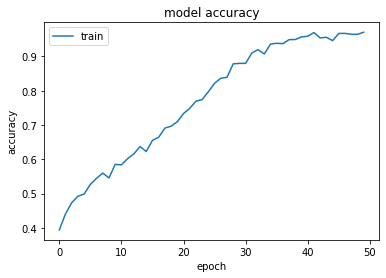

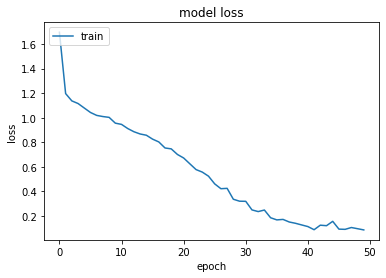

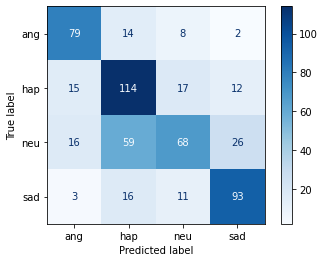

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0442649126052856 - Accuracy: 66.7870044708252% - F1: 66.71505397195095
------------------------------------------------------------------------
> Fold 2 - Loss: 1.3183014392852783 - Accuracy: 62.386977672576904% - F1: 62.164694451640834
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1769238710403442 - Accuracy: 64.01446461677551% - F1: 63.05420071741036
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 64.3961489200592 (+- 1.81646564090005)
> Loss: 1.1798300743103027
> F1: 63.97798304700072
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
156/156 [========================

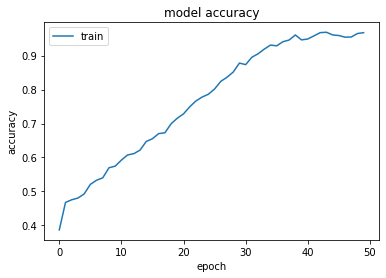

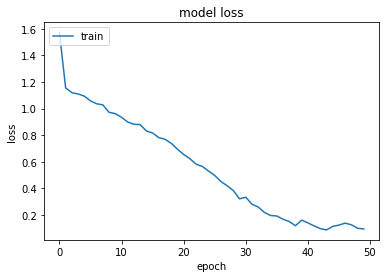

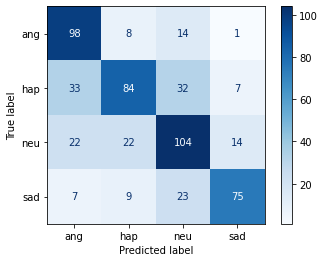

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0442649126052856 - Accuracy: 66.7870044708252% - F1: 66.71505397195095
------------------------------------------------------------------------
> Fold 2 - Loss: 1.3183014392852783 - Accuracy: 62.386977672576904% - F1: 62.164694451640834
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1769238710403442 - Accuracy: 64.01446461677551% - F1: 63.05420071741036
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0238491296768188 - Accuracy: 65.28028845787048% - F1: 65.09254774660488
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 64.61718380451202 (+- 1.6190212564580604)
> Loss: 1.1408348381519318
> F1: 64.25662422190176
-----------------------------------------------

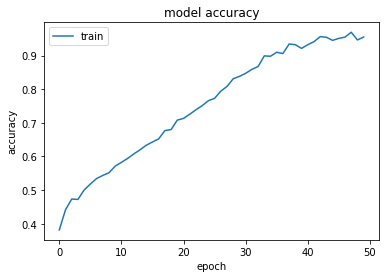

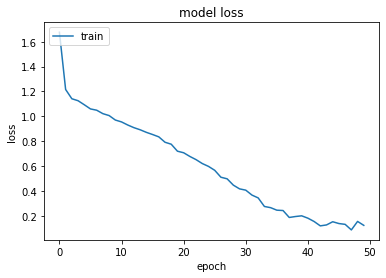

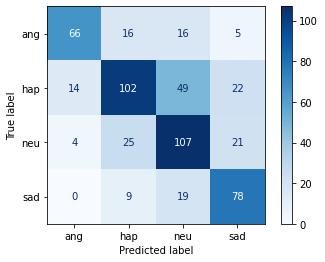

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0442649126052856 - Accuracy: 66.7870044708252% - F1: 66.71505397195095
------------------------------------------------------------------------
> Fold 2 - Loss: 1.3183014392852783 - Accuracy: 62.386977672576904% - F1: 62.164694451640834
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1769238710403442 - Accuracy: 64.01446461677551% - F1: 63.05420071741036
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0238491296768188 - Accuracy: 65.28028845787048% - F1: 65.09254774660488
------------------------------------------------------------------------
> Fold 5 - Loss: 1.163333535194397 - Accuracy: 63.83363604545593% - F1: 63.844248622916524
------------------------------------------------------------------------
Average scores for

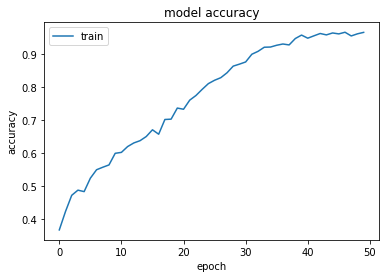

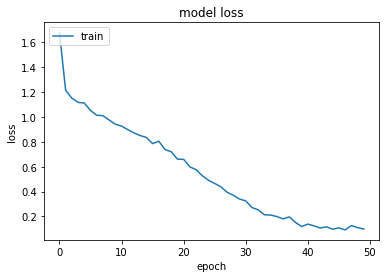

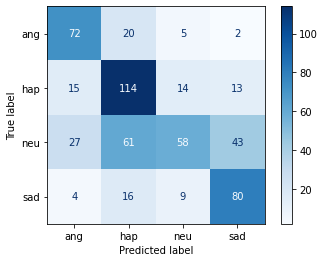

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0442649126052856 - Accuracy: 66.7870044708252% - F1: 66.71505397195095
------------------------------------------------------------------------
> Fold 2 - Loss: 1.3183014392852783 - Accuracy: 62.386977672576904% - F1: 62.164694451640834
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1769238710403442 - Accuracy: 64.01446461677551% - F1: 63.05420071741036
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0238491296768188 - Accuracy: 65.28028845787048% - F1: 65.09254774660488
------------------------------------------------------------------------
> Fold 5 - Loss: 1.163333535194397 - Accuracy: 63.83363604545593% - F1: 63.844248622916524
------------------------------------------------------------------------
> Fold 6 - Loss: 1

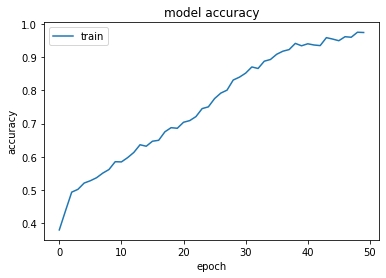

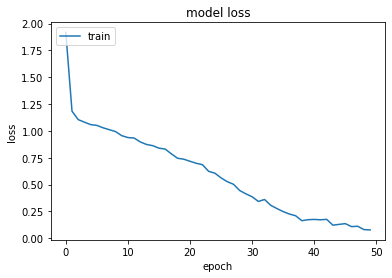

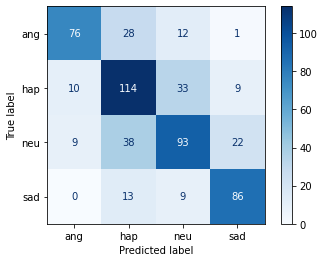

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0442649126052856 - Accuracy: 66.7870044708252% - F1: 66.71505397195095
------------------------------------------------------------------------
> Fold 2 - Loss: 1.3183014392852783 - Accuracy: 62.386977672576904% - F1: 62.164694451640834
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1769238710403442 - Accuracy: 64.01446461677551% - F1: 63.05420071741036
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0238491296768188 - Accuracy: 65.28028845787048% - F1: 65.09254774660488
------------------------------------------------------------------------
> Fold 5 - Loss: 1.163333535194397 - Accuracy: 63.83363604545593% - F1: 63.844248622916524
------------------------------------------------------------------------
> Fold 6 - Loss: 1

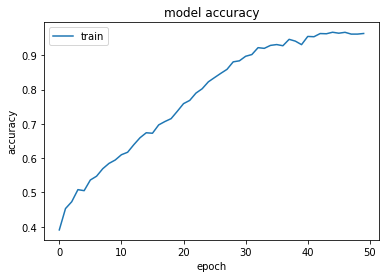

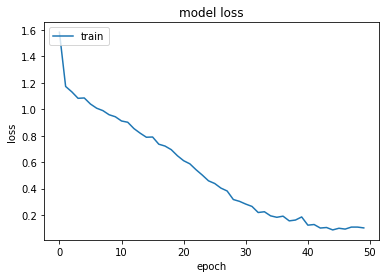

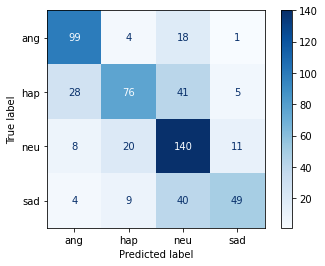

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0442649126052856 - Accuracy: 66.7870044708252% - F1: 66.71505397195095
------------------------------------------------------------------------
> Fold 2 - Loss: 1.3183014392852783 - Accuracy: 62.386977672576904% - F1: 62.164694451640834
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1769238710403442 - Accuracy: 64.01446461677551% - F1: 63.05420071741036
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0238491296768188 - Accuracy: 65.28028845787048% - F1: 65.09254774660488
------------------------------------------------------------------------
> Fold 5 - Loss: 1.163333535194397 - Accuracy: 63.83363604545593% - F1: 63.844248622916524
------------------------------------------------------------------------
> Fold 6 - Loss: 1

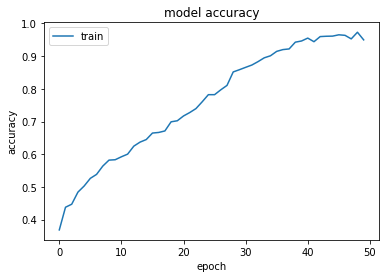

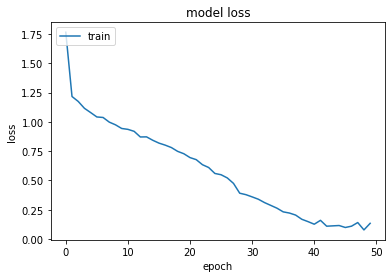

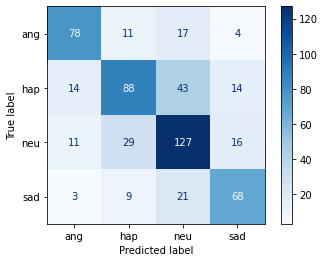

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0442649126052856 - Accuracy: 66.7870044708252% - F1: 66.71505397195095
------------------------------------------------------------------------
> Fold 2 - Loss: 1.3183014392852783 - Accuracy: 62.386977672576904% - F1: 62.164694451640834
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1769238710403442 - Accuracy: 64.01446461677551% - F1: 63.05420071741036
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0238491296768188 - Accuracy: 65.28028845787048% - F1: 65.09254774660488
------------------------------------------------------------------------
> Fold 5 - Loss: 1.163333535194397 - Accuracy: 63.83363604545593% - F1: 63.844248622916524
------------------------------------------------------------------------
> Fold 6 - Loss: 1

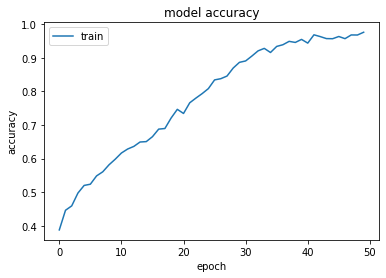

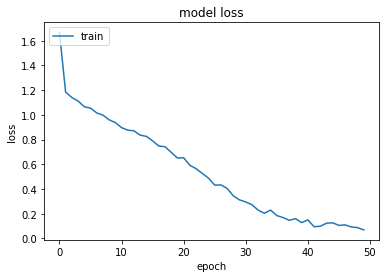

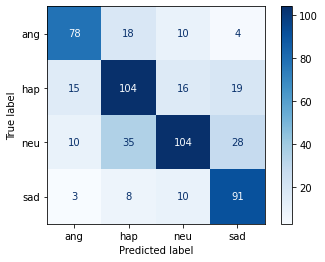

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.0442649126052856 - Accuracy: 66.7870044708252% - F1: 66.71505397195095
------------------------------------------------------------------------
> Fold 2 - Loss: 1.3183014392852783 - Accuracy: 62.386977672576904% - F1: 62.164694451640834
------------------------------------------------------------------------
> Fold 3 - Loss: 1.1769238710403442 - Accuracy: 64.01446461677551% - F1: 63.05420071741036
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0238491296768188 - Accuracy: 65.28028845787048% - F1: 65.09254774660488
------------------------------------------------------------------------
> Fold 5 - Loss: 1.163333535194397 - Accuracy: 63.83363604545593% - F1: 63.844248622916524
------------------------------------------------------------------------
> Fold 6 - Loss: 1

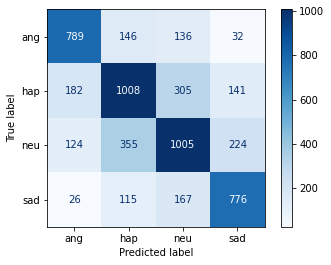

In [ ]:
k_fold_fit_re('CNN', X, yy, folds=10, numepoch = 50, batchsize = 32)

In [ ]:
def strat_k_fold_fit_re(model_type,X, yy, folds=10, lr=0.0001, numepoch = 50, batchsize = 32):
  from sklearn.model_selection import StratifiedKFold
  from sklearn.metrics import ConfusionMatrixDisplay
  from sklearn.metrics import confusion_matrix
  from tensorflow.keras.optimizers import SGD
  from sklearn.preprocessing import LabelEncoder
  from sklearn.metrics import f1_score
  le = LabelEncoder()
  # Define per-fold score containers
  acc_per_fold = []
  loss_per_fold = []
  f1_per_fold = []
  verbosity = 1
  # Define the stratified K-fold Cross Validator
  kfold = StratifiedKFold(n_splits=folds, shuffle=True)
  # K-fold Cross Validation model evaluation
  fold_no = 1
  for train, test in kfold.split(X, y):
    #label encoding comes after the split
    yy = to_categorical(le.fit_transform(y))
    model = CNN()
    opt = keras.optimizers.Adam(learning_rate=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')
    # Fit data to model and save details to history
    history = model.fit(X[train], yy[train],
                batch_size=batchsize,
                epochs=numepoch,
                verbose=verbosity)
    # Generate generalization metrics
    scores = model.evaluate(X[test], yy[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    # Increase fold number
    fold_no = fold_no + 1
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train'], loc='upper left')
    plt.show()
    #Confusion matrix
    y_pred = np.argmax(model.predict(X[test]), axis=-1)
    matrix = metrics.confusion_matrix(yy[test].argmax(axis=1), y_pred)
    #f1 score
    f1_score_temp = f1_score(yy[test].argmax(axis=1), y_pred, average='weighted')
    f1_per_fold.append(f1_score_temp*100)
    #conf matrix ctnd
    rounded_labels= np.unique(le.inverse_transform(np.argmax(yy[test], axis=1)))
    disp = ConfusionMatrixDisplay(confusion_matrix=matrix, display_labels=rounded_labels)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()
    # == Print average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(acc_per_fold)):
      print('------------------------------------------------------------------------')
      print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}% - F1: {f1_per_fold[i]}%')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
    print(f'> Loss: {np.mean(loss_per_fold)}')
    print(f'> F1: {np.mean(f1_per_fold)}')
    print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/50
156/156 [==============================] - 35s 220ms/step - loss: 1.7946 - accuracy: 0.3896
Epoch 2/50
156/156 [==============================] - 34s 219ms/step - loss: 1.1811 - accuracy: 0.4424
Epoch 3/50
156/156 [==============================] - 34s 220ms/step - loss: 1.1442 - accuracy: 0.4698
Epoch 4/50
156/156 [==============================] - 34s 220ms/step - loss: 1.1229 - accuracy: 0.4706
Epoch 5/50
156/156 [==============================] - 34s 220ms/step - loss: 1.1085 - accuracy: 0.4854
Epoch 6/50
156/156 [==============================] - 34s 220ms/step - loss: 1.0720 - accuracy: 0.5103
Epoch 7/50
156/156 [==============================] - 34s 220ms/step - loss: 1.0196 - accuracy: 0.5457
Epoch 8/50
156/156 [==============================] - 34s 220ms/step - loss: 1.0067 - accuracy: 0.5467
Epoch 9/50
156/156 [==============================] - 34s 220ms/step - loss: 0.

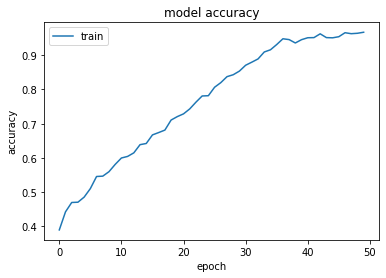

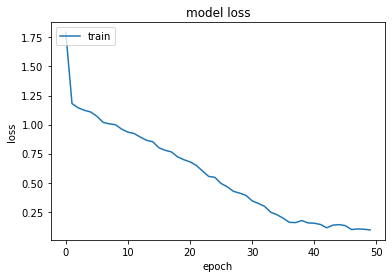

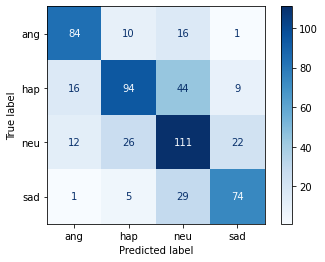

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.104036569595337 - Accuracy: 65.52346348762512% - F1: 65.60256733563293%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 65.52346348762512 (+- 0.0)
> Loss: 1.104036569595337
> F1: 65.60256733563293
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/50
156/156 [==============================] - 36s 221ms/step - loss: 1.6725 - accuracy: 0.3783
Epoch 2/50
156/156 [==============================] - 34s 220ms/step - loss: 1.1975 - accuracy: 0.4361
Epoch 3/50
156/156 [==============================] - 34s 221ms/step - loss: 1.1515 - accuracy: 0.4638
Epoch 4/50
156/156 [==============================] - 34s 220ms/step - loss: 

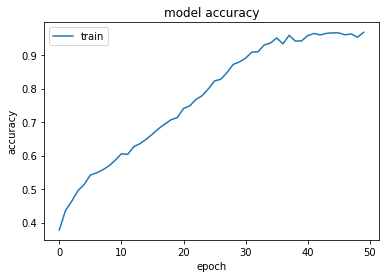

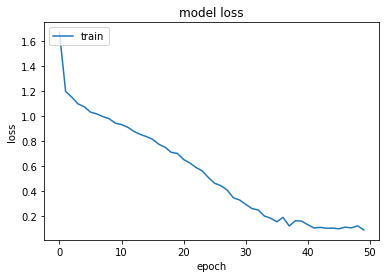

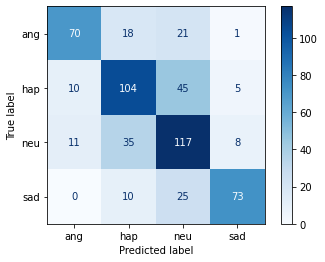

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.104036569595337 - Accuracy: 65.52346348762512% - F1: 65.60256733563293%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0748118162155151 - Accuracy: 65.82278609275818% - F1: 66.20500761459716%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 65.67312479019165 (+- 0.14966130256652832)
> Loss: 1.089424192905426
> F1: 65.90378747511505
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/50
156/156 [==============================] - 35s 220ms/step - loss: 1.5998 - accuracy: 0.3807
Epoch 2/50
156/156 [==============================] - 34s 219ms/step - loss: 1.1684 - accuracy: 0.4508

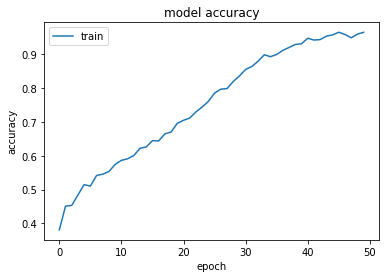

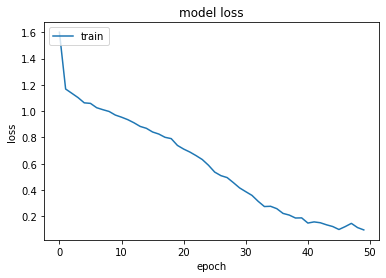

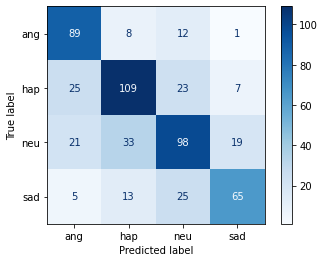

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.104036569595337 - Accuracy: 65.52346348762512% - F1: 65.60256733563293%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0748118162155151 - Accuracy: 65.82278609275818% - F1: 66.20500761459716%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.0867540836334229 - Accuracy: 65.28028845787048% - F1: 65.04985058930654%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 65.5421793460846 (+- 0.2218687802630075)
> Loss: 1.088534156481425
> F1: 65.61914184651222
------------------------------------------------------------------------
------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/50
156/156 [======================

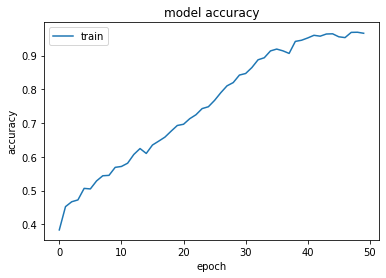

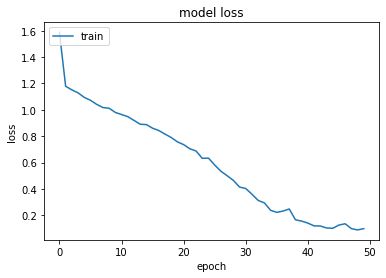

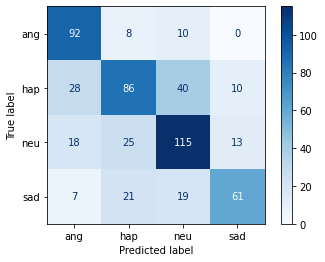

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.104036569595337 - Accuracy: 65.52346348762512% - F1: 65.60256733563293%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0748118162155151 - Accuracy: 65.82278609275818% - F1: 66.20500761459716%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.0867540836334229 - Accuracy: 65.28028845787048% - F1: 65.04985058930654%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0265246629714966 - Accuracy: 64.01446461677551% - F1: 63.576085912872436%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 65.16025066375732 (+- 0.6888598347227696)
> Loss: 1.0730317831039429
> F1: 65.10837786310228
--------------------------------------------

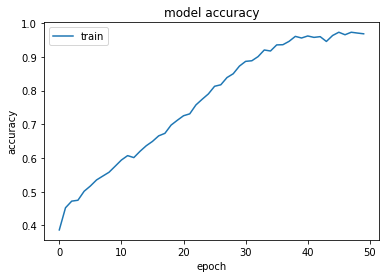

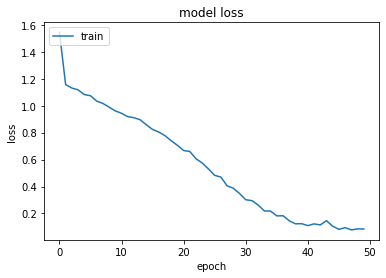

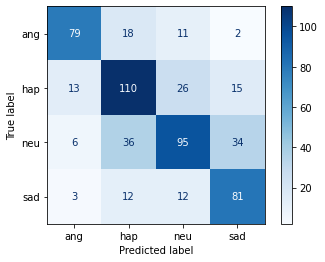

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.104036569595337 - Accuracy: 65.52346348762512% - F1: 65.60256733563293%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0748118162155151 - Accuracy: 65.82278609275818% - F1: 66.20500761459716%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.0867540836334229 - Accuracy: 65.28028845787048% - F1: 65.04985058930654%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0265246629714966 - Accuracy: 64.01446461677551% - F1: 63.576085912872436%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.1764068603515625 - Accuracy: 66.00361466407776% - F1: 65.91865686222896%
------------------------------------------------------------------------
Average scores

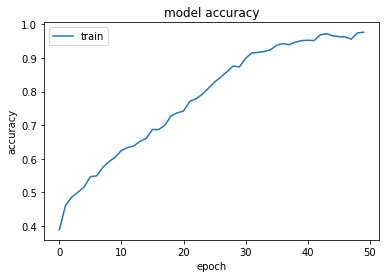

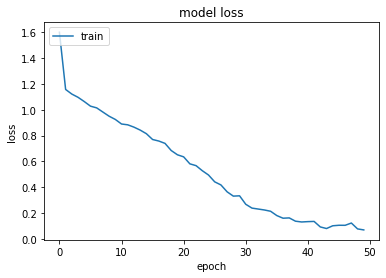

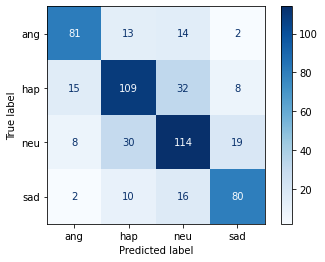

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.104036569595337 - Accuracy: 65.52346348762512% - F1: 65.60256733563293%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0748118162155151 - Accuracy: 65.82278609275818% - F1: 66.20500761459716%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.0867540836334229 - Accuracy: 65.28028845787048% - F1: 65.04985058930654%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0265246629714966 - Accuracy: 64.01446461677551% - F1: 63.576085912872436%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.1764068603515625 - Accuracy: 66.00361466407776% - F1: 65.91865686222896%
------------------------------------------------------------------------
> Fold 6 - Los

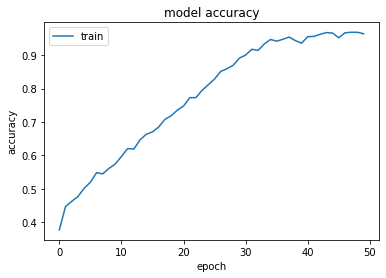

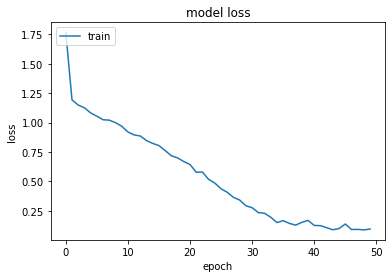

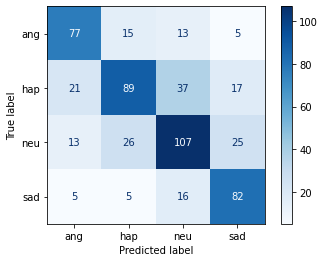

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.104036569595337 - Accuracy: 65.52346348762512% - F1: 65.60256733563293%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0748118162155151 - Accuracy: 65.82278609275818% - F1: 66.20500761459716%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.0867540836334229 - Accuracy: 65.28028845787048% - F1: 65.04985058930654%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0265246629714966 - Accuracy: 64.01446461677551% - F1: 63.576085912872436%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.1764068603515625 - Accuracy: 66.00361466407776% - F1: 65.91865686222896%
------------------------------------------------------------------------
> Fold 6 - Los

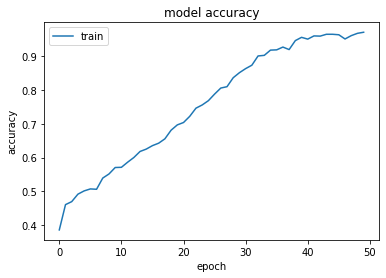

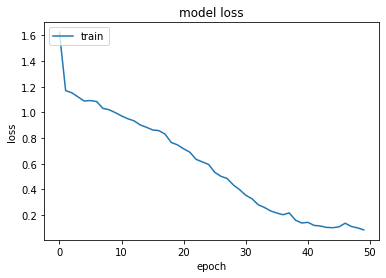

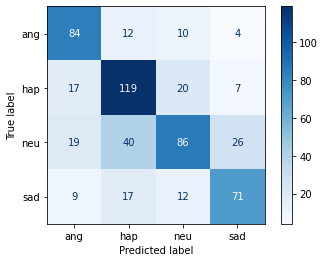

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.104036569595337 - Accuracy: 65.52346348762512% - F1: 65.60256733563293%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0748118162155151 - Accuracy: 65.82278609275818% - F1: 66.20500761459716%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.0867540836334229 - Accuracy: 65.28028845787048% - F1: 65.04985058930654%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0265246629714966 - Accuracy: 64.01446461677551% - F1: 63.576085912872436%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.1764068603515625 - Accuracy: 66.00361466407776% - F1: 65.91865686222896%
------------------------------------------------------------------------
> Fold 6 - Los

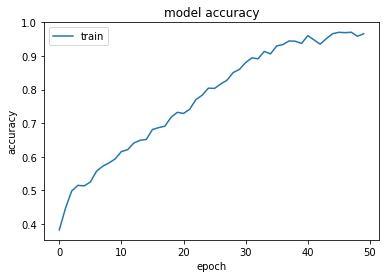

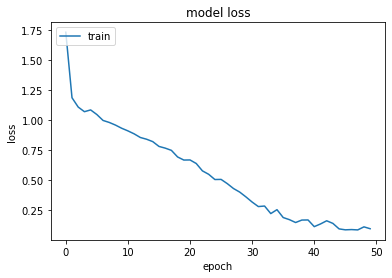

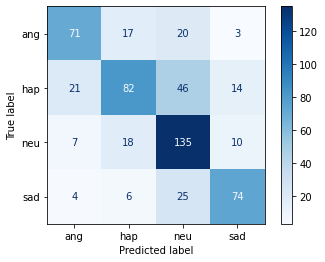

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.104036569595337 - Accuracy: 65.52346348762512% - F1: 65.60256733563293%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0748118162155151 - Accuracy: 65.82278609275818% - F1: 66.20500761459716%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.0867540836334229 - Accuracy: 65.28028845787048% - F1: 65.04985058930654%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0265246629714966 - Accuracy: 64.01446461677551% - F1: 63.576085912872436%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.1764068603515625 - Accuracy: 66.00361466407776% - F1: 65.91865686222896%
------------------------------------------------------------------------
> Fold 6 - Los

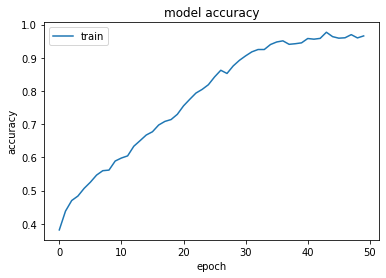

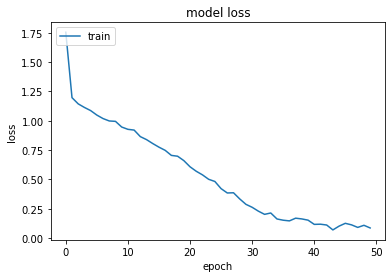

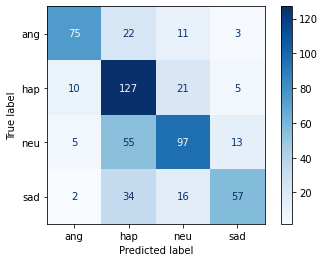

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 1.104036569595337 - Accuracy: 65.52346348762512% - F1: 65.60256733563293%
------------------------------------------------------------------------
> Fold 2 - Loss: 1.0748118162155151 - Accuracy: 65.82278609275818% - F1: 66.20500761459716%
------------------------------------------------------------------------
> Fold 3 - Loss: 1.0867540836334229 - Accuracy: 65.28028845787048% - F1: 65.04985058930654%
------------------------------------------------------------------------
> Fold 4 - Loss: 1.0265246629714966 - Accuracy: 64.01446461677551% - F1: 63.576085912872436%
------------------------------------------------------------------------
> Fold 5 - Loss: 1.1764068603515625 - Accuracy: 66.00361466407776% - F1: 65.91865686222896%
------------------------------------------------------------------------
> Fold 6 - Los

In [ ]:
strat_k_fold_fit_re('CNN', X, yy, folds=10, lr=0.0001, numepoch = 50, batchsize = 32)

Epoch 1/80
139/139 [==============================] - ETA: 0s - loss: 1.5279 - accuracy: 0.3915
Epoch 1: val_accuracy improved from -inf to 0.20235, saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_plaincnn.h5
139/139 [==============================] - 36s 250ms/step - loss: 1.5279 - accuracy: 0.3915 - val_loss: 1.8402 - val_accuracy: 0.2023
Epoch 2/80
139/139 [==============================] - ETA: 0s - loss: 1.1819 - accuracy: 0.4478
Epoch 2: val_accuracy improved from 0.20235 to 0.51039, saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_plaincnn.h5
139/139 [==============================] - 33s 235ms/step - loss: 1.1819 - accuracy: 0.4478 - val_loss: 1.1067 - val_accuracy: 0.5104
Epoch 3/80
139/139 [==============================] - ETA: 0s - loss: 1.1269 - accuracy: 0.4756
Epoch 3: val_accuracy improved from 0.51039 to 0.52213, saving model to /content/drive/MyDrive/Colab_Notebooks/CNN_IEMO

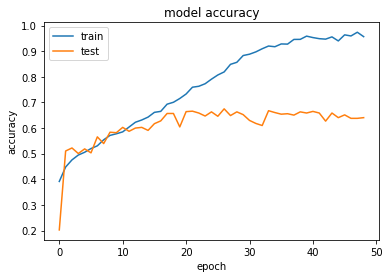

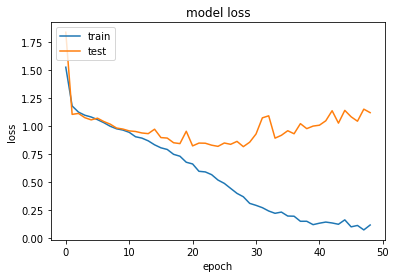

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
n_splits = 1  # We only want a single split in this case
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=None)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
mc = ModelCheckpoint('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_plaincnn.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
for train_index, test_index in sss.split(X, y):
    yy = to_categorical(le.fit_transform(y))
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = yy[train_index], yy[test_index]
    model = CNN()
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=32, epochs=80, verbose=1, callbacks=[es, mc])
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
saved_model = load_model('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/best_plaincnn.h5')

In [ ]:
model = CNN()
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt)
history = model.fit(X, yy,
                batch_size=32,
                epochs=80,
                verbose=1)

Epoch 1/80
173/173 [==============================] - 42s 235ms/step - loss: 1.6265
Epoch 2/80
173/173 [==============================] - 38s 221ms/step - loss: 1.1523
Epoch 3/80
173/173 [==============================] - 38s 220ms/step - loss: 1.0983
Epoch 4/80
173/173 [==============================] - 38s 220ms/step - loss: 1.0568
Epoch 5/80
173/173 [==============================] - 38s 220ms/step - loss: 1.0336
Epoch 6/80
173/173 [==============================] - 38s 221ms/step - loss: 1.0070
Epoch 7/80
173/173 [==============================] - 38s 220ms/step - loss: 0.9936
Epoch 8/80
173/173 [==============================] - 38s 221ms/step - loss: 0.9597
Epoch 9/80
173/173 [==============================] - 38s 221ms/step - loss: 0.9270
Epoch 10/80
173/173 [==============================] - 38s 220ms/step - loss: 0.9236
Epoch 11/80
173/173 [==============================] - 38s 221ms/step - loss: 0.8933
Epoch 12/80
173/173 [==============================] - 38s 220ms/step - lo

In [ ]:
model.save('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/plaincnn.h5') 

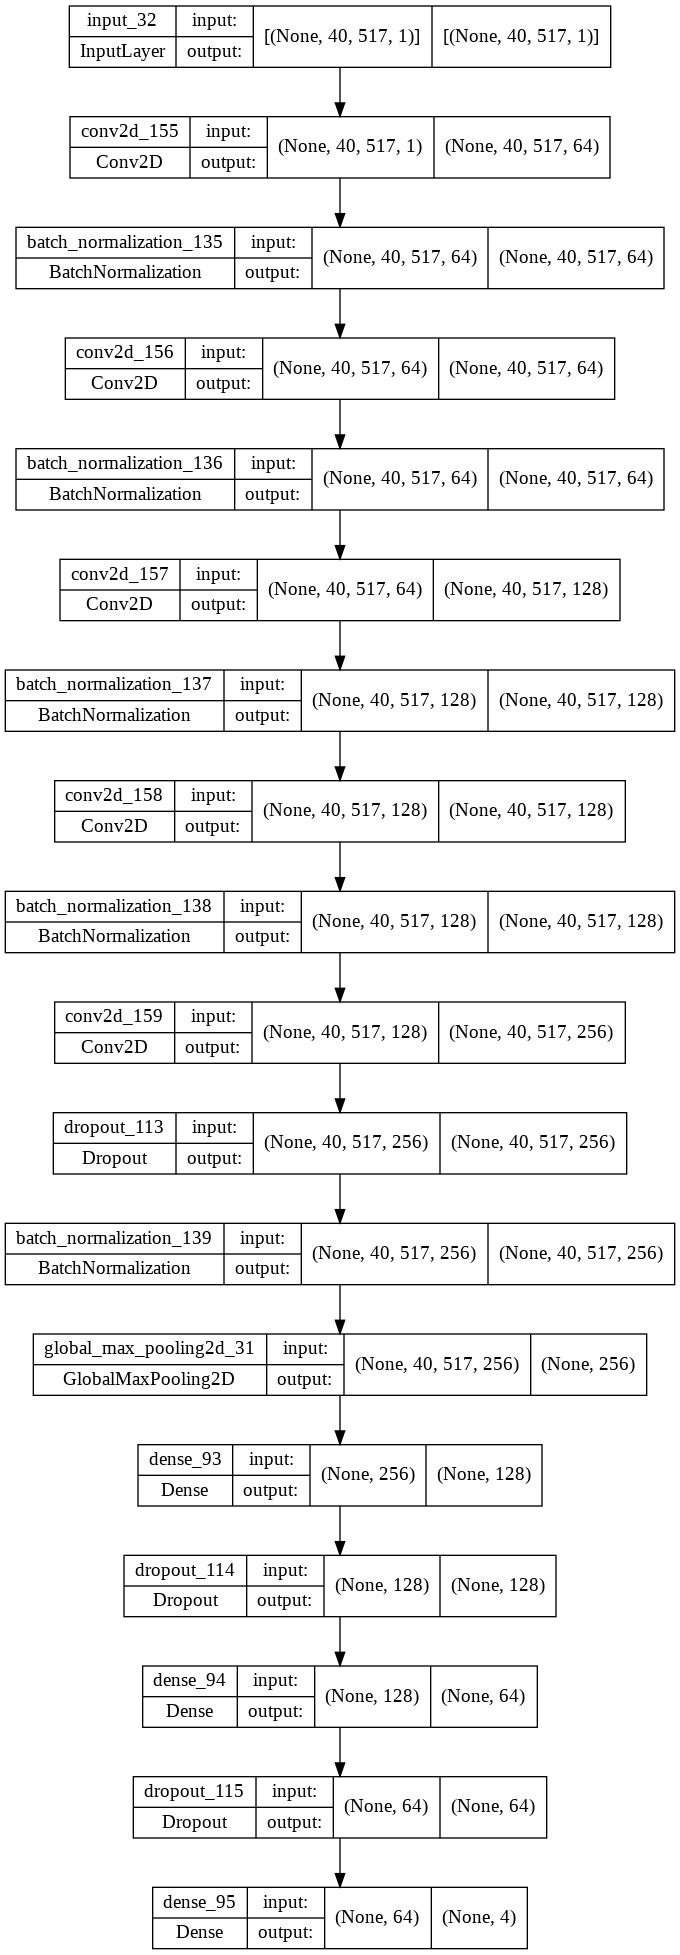

In [ ]:
keras.utils.plot_model(CNN(), "/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/plain_cnn.png", show_shapes=True)

#Application


In [ ]:
!pip install ffmpeg-python
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
from scipy.io.wavfile import read as wav_read
import io
import ffmpeg

AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    bitsPerSecond: 22050, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };            
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {            
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data); 
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});
      
</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)
  
  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  sr, audio = wav_read(io.BytesIO(riff))

  return audio, sr

In [ ]:
import librosa.display
def record_audio():  
  audio, sr = get_audio()
  samples_orig = audio.shape[0]/48000
  print(f'duration is {samples_orig}')
  if(samples_orig > 12):
    audio = audio[:12*48000]
  else:
    N_pad = abs(12*48000-audio.shape[0])
    print(N_pad/48000)
    audio = np.hstack((audio,np.zeros(N_pad)))
  print(audio.shape[0]/48000)
  arr = np.array(audio).astype(np.float32)
  arr = librosa.resample(arr, orig_sr=48000, target_sr=22050)
  
  plt.title('Recorded audio')
  librosa.display.waveplot(arr, sr= 22050)
  mfccs = librosa.feature.mfcc(y=arr, sr=22050, n_mfcc = 40)
  # mfccs = librosa.feature.mfcc(y=arr, sr=48000, n_mfcc = 40)
  plt.figure(figsize=(8,8))
  librosa.display.specshow(mfccs, sr=22050, x_axis='time')
  return mfccs

In [ ]:
def classify(mfccs, model,isTranspose=False): 
  labels = ['angry','happy','neutral','sad']
  if(isTranspose):
    temparr =  model.predict(mfccs.reshape(1,517,40))
  temparr =  model.predict(mfccs.reshape(1,40,517))
  print(f'Emotion of the speech most possibly is ... {labels[np.argmax(temparr)]}')
  print(temparr)

In [ ]:
import tensorflow as tf
from tensorflow import keras
mark = tf.keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/CNN_IEMOCAP_Experiment2/Experiments/plaincnn.h5')

duration is 4.14
7.86
12.0
Emotion of the speech most possibly is ... sad
[[1.7683669e-03 1.6502682e-07 6.8702747e-04 9.9754447e-01]]


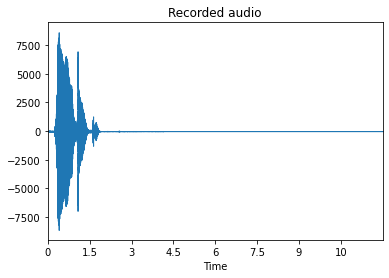

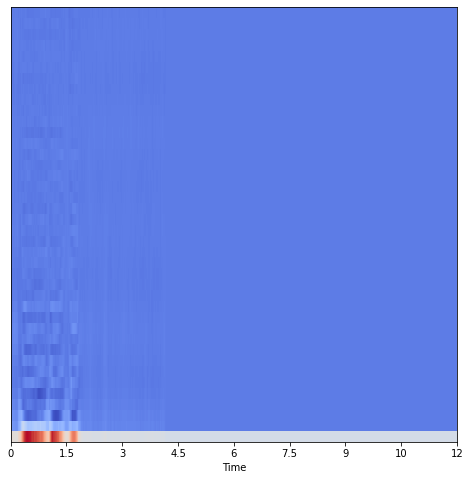

In [ ]:
data = record_audio()
classify(data,mark)